### Installing Dependencies


In [41]:
pip install tensorflow tensorflow-gpu opencv-python albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/Users/qamarali/miniconda3/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/Users/qamarali/miniconda3/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/Users/qamarali/miniconda3/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/Users/qamarali/miniconda3/lib/python3.10/site-packages/setuptools/_vendor/packa

In [42]:
### collect images using openCV

In [43]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [44]:
import os
import time
import uuid

In [45]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [46]:
Images_path = os.path.join('data', 'images')
number_images = 30

In [47]:
import cv2


In [48]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('collecting images {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(Images_path, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Annotate Images using labelme from terminal


## Review Dataset and build image loading function

In [49]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [50]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### load images into TF Data Pipeline

In [51]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [52]:
images.as_numpy_iterator().next()

b'data/images/9d3aa838-4189-11ee-aca3-f2b2c20eb1b6.jpg'

In [53]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [54]:
images = images.map(load_image)

In [55]:
images.as_numpy_iterator().next()

array([[[ 1,  3,  2],
        [ 0,  2,  1],
        [ 0,  2,  1],
        ...,
        [ 5, 11, 11],
        [ 2,  8,  8],
        [ 3,  9,  9]],

       [[ 0,  2,  1],
        [ 0,  1,  0],
        [ 0,  2,  1],
        ...,
        [ 3,  9,  9],
        [ 4, 10, 10],
        [ 4, 10, 10]],

       [[ 0,  2,  1],
        [ 0,  2,  1],
        [ 1,  3,  2],
        ...,
        [ 3,  7,  8],
        [ 7, 11, 12],
        [ 5,  9, 10]],

       ...,

       [[ 0,  2,  1],
        [ 0,  2,  1],
        [ 0,  2,  1],
        ...,
        [ 2,  6,  5],
        [ 0,  4,  3],
        [ 1,  5,  4]],

       [[ 0,  2,  1],
        [ 0,  1,  0],
        [ 0,  1,  0],
        ...,
        [ 3,  7,  6],
        [ 0,  4,  3],
        [ 0,  3,  2]],

       [[ 0,  2,  1],
        [ 0,  2,  1],
        [ 0,  2,  1],
        ...,
        [ 0,  4,  3],
        [ 0,  4,  3],
        [ 0,  3,  2]]], dtype=uint8)

In [56]:
type(images)


tensorflow.python.data.ops.map_op._MapDataset

### view random images with Matplotlib

In [57]:
image_generator = images.batch(4).as_numpy_iterator()

In [58]:
plot_images = image_generator.next()

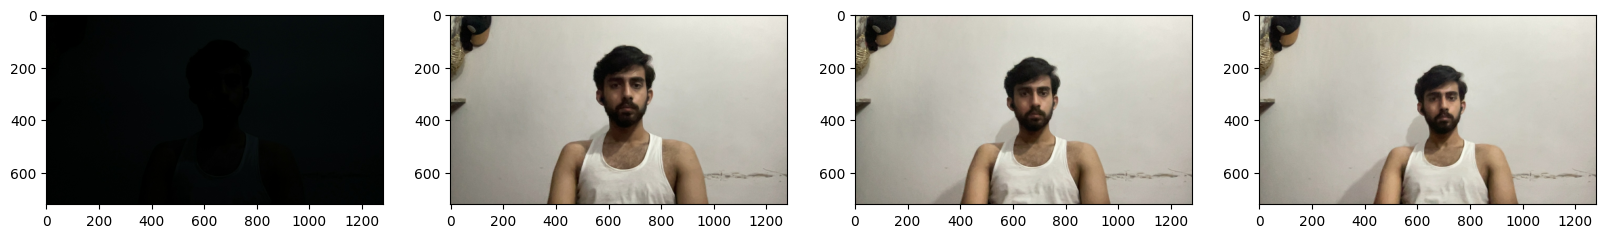

In [59]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## Partition Unaugmented Data

###  split data into train, test and validation split

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
pip install split-folders


Note: you may need to restart the kernel to use updated packages.


In [62]:
import splitfolders

In [63]:
splitfolders.ratio('Data', output="data", seed=1337, ratio=(.7, 0.15,0.15)) 


Copying files: 155 files [00:00, 1786.19 files/s]


 ## Apply Image Augmentation Using Albumentations

### Setup albumentations pipeline

In [64]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [65]:
import albumentations as alb

In [66]:
augmentor = alb.Compose([
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.3),
        alb.RandomRain(p=1.0),
        alb.RandomGamma(p=0.2),
        alb.RandomCrop(width=650, height=650),
        alb.RandomBrightnessContrast(p=0.2),
        alb.RGBShift(p=0.2),],
       bbox_params=alb.BboxParams(format='albumentations',
                                   label_fields = ['class_labels']))

In [67]:
img = cv2.imread(os.path.join('data/train/images/f270d4b4-4187-11ee-aca3-f2b2c20eb1b6.jpg'))

In [68]:
img.shape

(720, 1280, 3)

In [69]:
with open(os.path.join('data/train/labels/f270d4b4-4187-11ee-aca3-f2b2c20eb1b6.json'), 'r') as f:
    label = json.load(f)

In [70]:
label['shapes'][0]['points']

[[514.4565217391304, 272.5], [765.5434782608695, 526.8478260869565]]

### Extract Coordinates and Rescale to match Resolution

In [71]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [72]:
coords

[514.4565217391304, 272.5, 765.5434782608695, 526.8478260869565]

In [73]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [74]:
coords

[0.4019191576086956,
 0.3784722222222222,
 0.5980808423913043,
 0.7317330917874396]

In [75]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [76]:
augmented['bboxes']

[(0.6145484949832775, 0.39, 1.0, 0.7813043478260869)]

In [77]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

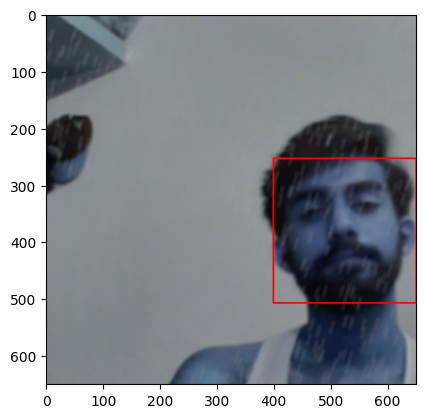

In [78]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [650,650]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [650,650]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Build and Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

## Load Augmented images to tensorflow dataset

In [80]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)


In [81]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [82]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [83]:
train_images.as_numpy_iterator().next()

array([[[0.19215687, 0.19607843, 0.20392157],
        [0.19215687, 0.19607843, 0.20392157],
        [0.19215687, 0.19607843, 0.20392157],
        ...,
        [0.1882353 , 0.20392157, 0.20032696],
        [0.25978348, 0.2833129 , 0.2833129 ],
        [0.2769549 , 0.29264116, 0.29656273]],

       [[0.19215687, 0.19607843, 0.20392157],
        [0.19215687, 0.19607843, 0.20392157],
        [0.19215687, 0.19607843, 0.20392157],
        ...,
        [0.18813312, 0.2038194 , 0.20304336],
        [0.20900735, 0.22469363, 0.2286152 ],
        [0.3183821 , 0.3340684 , 0.33798996]],

       [[0.19215687, 0.19607843, 0.20392157],
        [0.19215687, 0.19607843, 0.20392157],
        [0.19215687, 0.19607843, 0.20392157],
        ...,
        [0.18791524, 0.20391467, 0.20766602],
        [0.18431373, 0.20784314, 0.20784314],
        [0.27761358, 0.29362667, 0.29738483]],

       ...,

       [[0.22807075, 0.22807075, 0.2277438 ],
        [0.23768379, 0.23768379, 0.23735684],
        [0.23936553, 0

## Prepare labels

### build label loading function

In [84]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [85]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [86]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [87]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [88]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [89]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4740, 4740, 1440, 1440, 1260, 1260)

## Create Final Datasets

In [90]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(2000)
train = train.batch(8)
train = train.prefetch(4)

In [91]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [92]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)

In [93]:
train.as_numpy_iterator().next()


(array([[[[6.33830369e-01, 6.33830369e-01, 6.02457821e-01],
          [6.23018801e-01, 6.23018801e-01, 5.91646254e-01],
          [6.24346375e-01, 6.24346375e-01, 5.92973828e-01],
          ...,
          [1.51144430e-01, 1.59151033e-01, 1.39216244e-01],
          [1.56372547e-01, 1.60294116e-01, 1.40686274e-01],
          [1.83496743e-01, 1.91339880e-01, 1.79575175e-01]],
 
         [[6.29901946e-01, 6.29901946e-01, 5.98529398e-01],
          [6.27451003e-01, 6.29901946e-01, 5.98529398e-01],
          [6.25000000e-01, 6.25000000e-01, 5.93627453e-01],
          ...,
          [1.77983001e-01, 1.77002609e-01, 1.59682274e-01],
          [1.88786760e-01, 1.92708328e-01, 1.73100486e-01],
          [1.30066633e-01, 1.37909770e-01, 1.26145065e-01]],
 
         [[6.31209135e-01, 6.31209135e-01, 5.99836588e-01],
          [6.18566155e-01, 6.22487724e-01, 5.91115177e-01],
          [6.23529434e-01, 6.23529434e-01, 5.92156887e-01],
          ...,
          [2.46243015e-01, 2.30720222e-01, 2.1862

In [94]:
data_samples = train.as_numpy_iterator()

In [95]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


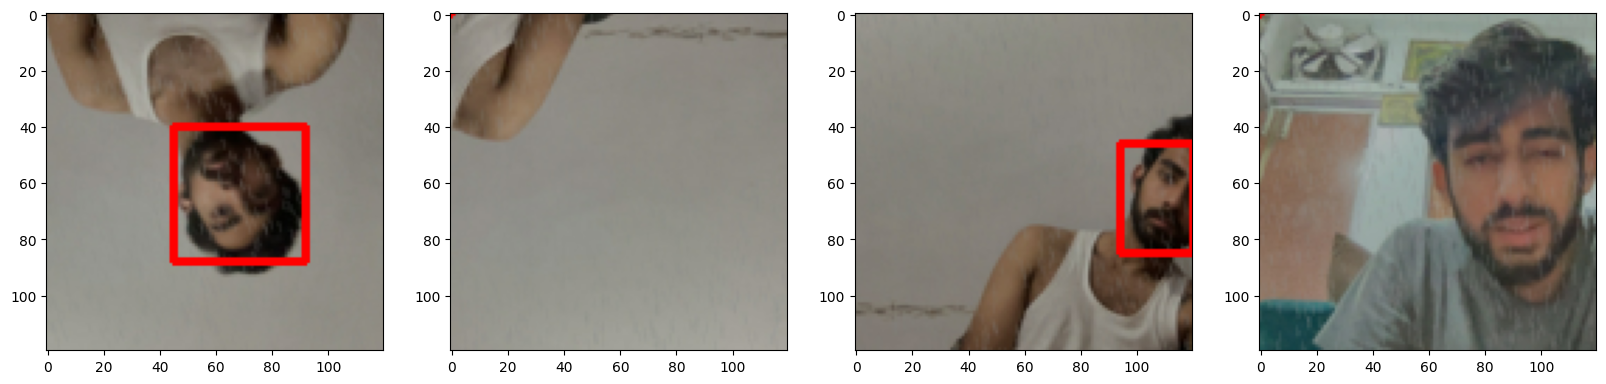

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Build DL using functional API

In [97]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG 16

In [98]:
vgg = VGG16(include_top=False)

In [99]:
vgg.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [100]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## Testing the NN

In [101]:
facetracker = build_model()

In [102]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [103]:
X, y = train.as_numpy_iterator().next()

In [104]:
X.shape

(8, 120, 120, 3)

In [105]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 302ms/step


In [106]:
classes, coords

(array([[0.48525706],
        [0.48034525],
        [0.56900066],
        [0.5334429 ],
        [0.47328064],
        [0.48948258],
        [0.52425635],
        [0.48141068]], dtype=float32),
 array([[0.5366993 , 0.42558563, 0.4605742 , 0.5739857 ],
        [0.4793824 , 0.4156964 , 0.5883742 , 0.57847226],
        [0.47844085, 0.42777705, 0.4472411 , 0.70780855],
        [0.56439596, 0.40783295, 0.475918  , 0.48391178],
        [0.554831  , 0.45652878, 0.43429878, 0.5679633 ],
        [0.5600066 , 0.46197456, 0.499962  , 0.51661086],
        [0.4551354 , 0.45586625, 0.5422808 , 0.5704788 ],
        [0.5355831 , 0.43430066, 0.47949648, 0.47528708]], dtype=float32))

### Define Losses and Optimisers

#### Define Optimizer and LR

In [107]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [108]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [109]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [110]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [111]:
localization_loss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=3.9150596>

In [112]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=0.69631654>

In [113]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.9150596>

### Train Neural Network

In [114]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [115]:
model = FaceTracker(facetracker)


In [116]:
model.compile(opt, classloss, regressloss)

In [117]:
logdir = 'logs'

In [118]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [119]:
# hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


In [120]:
hist.history

NameError: name 'hist' is not defined

NameError: name 'hist' is not defined

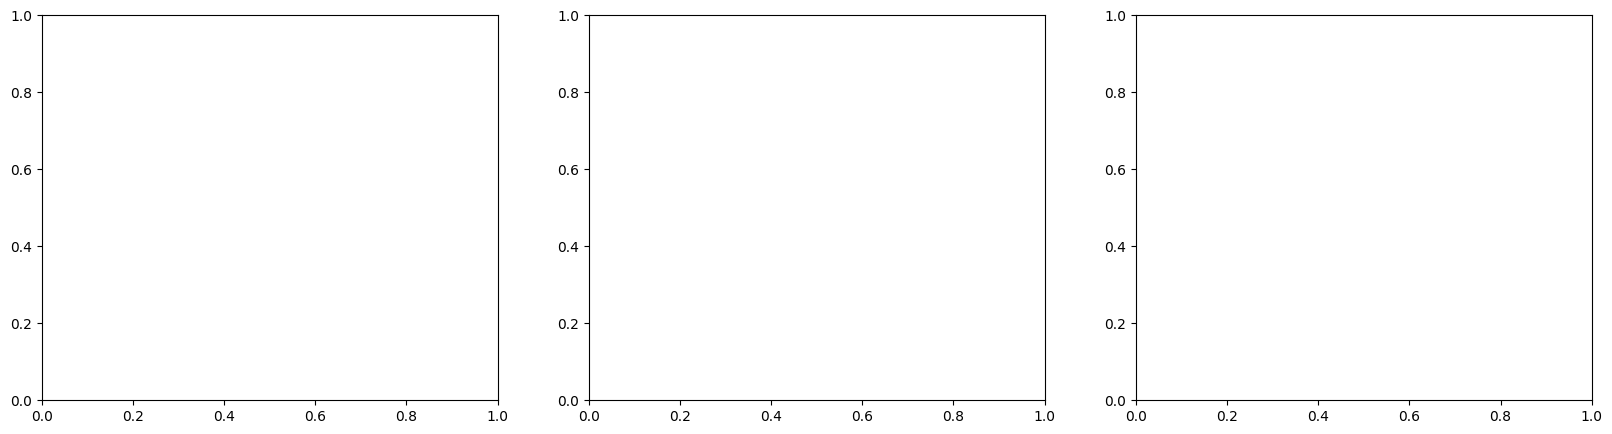

In [121]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions

In [122]:
test_data = test.as_numpy_iterator()

In [123]:
test_sample = test_data.next()


In [124]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 263ms/step


Copying files: 18 files [02:16,  7.57s/ files]


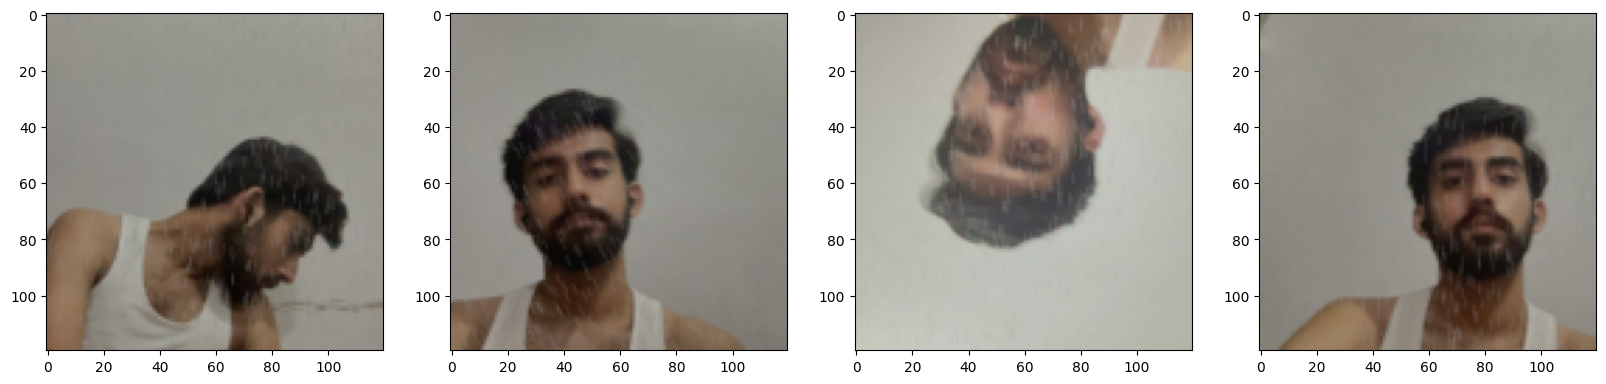

In [125]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [126]:
from tensorflow.keras.models import load_model

In [127]:
facetracker.save('facetracker.h5')

/Users/qamarali/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [650,650]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [650,650]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [650,650]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [650,650]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [650,650]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 42ms/step
